In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


import pickle
from tqdm import tqdm
import os
from collections import Counter

In [2]:
Project_data = pd.read_csv("train.csv")
Resources_data = pd.read_csv("resources.csv")
print("Shape of Train data ",Project_data.shape)
print("Shape of Train data ",Resources_data.shape)
print("-"*100)
print("The attributes in Resources_data are as folows " , "  -> "*5,Resources_data.columns.values)
print("The attributes in Project_data are as folows " , "  ->  "*5,Project_data.columns.values)


Shape of Train data  (182080, 16)
Shape of Train data  (1541272, 4)
----------------------------------------------------------------------------------------------------
The attributes in Resources_data are as folows    ->   ->   ->   ->   ->  ['id' 'description' 'quantity' 'price']
The attributes in Project_data are as folows    ->    ->    ->    ->    ->   ['id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [3]:
# here the code is chainging the date and time format used in the data to a standard form  and replacing the data with the new format and 
# replacing the same coloum  refrence to same are given below

Project_data["Date"] = pd.to_datetime(Project_data["project_submitted_datetime"])
Project_data.drop("project_submitted_datetime",axis=1,inplace = True )
Project_data.sort_values(by=["Date"],inplace=True)
Project_data.head(2)

,id,teacher_id,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,Date
128730,p146022,f91a89d2b72a0f5ee14cd98bd8741fc2,Ms.,CA,Grades 6-8,Math & Science,Applied Sciences,Robotics and Programming,I love giving my students experiences. A new e...,My students can vary quite dramatically. I hav...,The student will use the Sparki Robots to lear...,The Sparki robots would add a motivation for t...,My students need four Sparki robots to help st...,30,1,2016-04-27 00:03:38
173035,p244738,64ef8a335f7206366c52c39f5bfd09b7,Ms.,TX,Grades PreK-2,"Literacy & Language, Math & Science","Foreign Languages, Mathematics",Help Us Finish Our 1st Year In School!,"We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,"This time, I am asking to improve three differ...",This project will have a huge impact on my stu...,My students need Linking Letter Monkeys and Sp...,1,1,2016-04-27 00:04:09


In [4]:
#find out the NAN values in the dataframe and fill with null

Project_data["teacher_prefix"] = Project_data["teacher_prefix"].fillna("null")
print("The number of NAN values in teacher_prefix Column is " + str(Project_data["teacher_prefix"].isnull().sum()))

The number of NAN values in teacher_prefix Column is 0


In [5]:
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

catogories = list(Project_data['project_subject_categories'].values)
cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The','')
        j = j.replace(' ','')
        temp+=j.strip()+" "
        temp = temp.replace('&','_') 
    cat_list.append(temp.strip().lower())
    
Project_data['clean_categories'] = cat_list
Project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in Project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))
print("The Worlds in sorted_cat_dict",sorted_cat_dict)

The Worlds in sorted_cat_dict {'warmth': 2327, 'care_hunger': 2327, 'history_civics': 9726, 'music_arts': 17054, 'appliedlearning': 20303, 'specialneeds': 22881, 'health_sports': 23712, 'math_science': 69248, 'literacy_language': 86988}


In [6]:
catogories1 = list(Project_data['project_subject_subcategories'].values)
cat_list1 = []
for i in catogories1:
    temp1 = ""
    for j in i.split(','): 
        if 'The' in j.split():
            j=j.replace('The','')
        j = j.replace(' ','') 
        temp1+=j.strip()+" " 
        temp1 = temp1.replace('&','_') 
    cat_list1.append(temp1.strip().lower())
    
Project_data['clean_sub_categories'] = cat_list1
Project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

from collections import Counter
my_counter1 = Counter()
for word in Project_data['clean_sub_categories'].values:
    my_counter1.update(word.split())

cat_dict1 = dict(my_counter1)
sorted_cat_dict1 = dict(sorted(cat_dict1.items(), key=lambda kv: kv[1]))
print("The Worlds in sorted_cat_dict1",sorted_cat_dict1)
for i in sorted_cat_dict1:
    print(i,sorted_cat_dict1[i]) 

The Worlds in sorted_cat_dict1 {'economics': 431, 'communityservice': 712, 'financialliteracy': 956, 'parentinvolvement': 1103, 'civics_government': 1294, 'extracurricular': 1332, 'foreignlanguages': 1496, 'nutritioneducation': 2236, 'warmth': 2327, 'care_hunger': 2327, 'socialsciences': 3149, 'performingarts': 3223, 'charactereducation': 3519, 'teamsports': 3643, 'other': 3948, 'college_careerprep': 4291, 'music': 5172, 'history_geography': 5258, 'earlydevelopment': 7149, 'esl': 7162, 'health_lifescience': 7175, 'gym_fitness': 7592, 'environmentalscience': 9436, 'visualarts': 10399, 'health_wellness': 17099, 'appliedsciences': 17966, 'specialneeds': 22881, 'literature_writing': 36974, 'mathematics': 46884, 'literacy': 56066}
economics 431
communityservice 712
financialliteracy 956
parentinvolvement 1103
civics_government 1294
extracurricular 1332
foreignlanguages 1496
nutritioneducation 2236
warmth 2327
care_hunger 2327
socialsciences 3149
performingarts 3223
charactereducation 3519
t

In [7]:
school_state = list(Project_data['school_state'].values)
school_state_list = []
for i in school_state:
    temp2 = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp2 +=j.strip()+" "
        temp2 = temp2.replace('&','_')
    school_state_list.append(temp2.strip().lower())

Project_data['School_state'] = school_state_list
Project_data.drop(['school_state'], axis=1, inplace=True)

my_counter3 = Counter()
for word in Project_data['School_state'].values:
    my_counter3.update(word.split())
    
school_state_dict = dict(my_counter3)
sorted_school_state_dict = dict(sorted(school_state_dict.items(), key=lambda kv: kv[1]))
print("The Values in sorted_school_state_dict : ", sorted_school_state_dict)

The Values in sorted_school_state_dict :  {'vt': 139, 'wy': 177, 'nd': 248, 'mt': 384, 'ri': 475, 'ne': 493, 'sd': 494, 'ak': 557, 'nh': 587, 'de': 589, 'me': 827, 'wv': 839, 'hi': 869, 'dc': 902, 'nm': 916, 'ks': 1060, 'ia': 1079, 'id': 1113, 'ar': 1757, 'co': 1887, 'mn': 2055, 'or': 2119, 'ky': 2172, 'ms': 2222, 'nv': 2297, 'md': 2480, 'ct': 2766, 'ut': 2814, 'tn': 2836, 'al': 2955, 'wi': 2983, 'va': 3446, 'az': 3614, 'nj': 3671, 'ok': 3829, 'wa': 3903, 'la': 3946, 'ma': 4054, 'oh': 4139, 'mo': 4247, 'in': 4314, 'pa': 5093, 'mi': 5324, 'sc': 6463, 'ga': 6636, 'il': 7332, 'nc': 8463, 'fl': 10359, 'ny': 12157, 'tx': 12304, 'ca': 25695}


In [8]:
# merge two column text dataframe: 


Project_data["essay"] =Project_data["project_essay_1"].map(str) +\
                        Project_data["project_essay_2"].map(str) +\
                        Project_data["project_essay_3"].map(str) +\
                        Project_data["project_essay_4"].map(str)

In [9]:
import re

def decontracted(phrase):
    
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'


stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [11]:
# Combining all the above stundents 


from tqdm import tqdm
preprocessed_essays = []

for sentance in tqdm(Project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|████████████████████████████████| 182080/182080 [02:33<00:00, 1183.12it/s]


In [12]:
from tqdm import tqdm
preprocessed_titles = []

for sentence in tqdm(Project_data['project_title'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|███████████████████████████████| 182080/182080 [00:06<00:00, 26058.33it/s]


In [13]:
Project_data["clean_titles"] = preprocessed_titles
Project_data.drop(["project_essay_1"],axis=1,inplace=True)
Project_data.drop(["project_essay_2"],axis=1,inplace=True)
Project_data.drop(["project_essay_3"],axis=1,inplace=True)
Project_data.drop(["project_essay_4"],axis=1,inplace=True)
Project_data.drop(["project_title"],axis=1,inplace=True)

In [14]:
print("Project_data Columns are - >>> " , Project_data.columns ,"Resources_data Columns  ", Resources_data.columns)

Project_data Columns are - >>>  Index(['id', 'teacher_id', 'teacher_prefix', 'project_grade_category',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'Date', 'clean_categories', 'clean_sub_categories', 'School_state',
       'essay', 'clean_titles'],
      dtype='object') Resources_data Columns   Index(['id', 'description', 'quantity', 'price'], dtype='object')


In [15]:
Price_data = Resources_data.groupby("id").agg({"price": "sum" ,"quantity" : "sum"}).reset_index()
Price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [16]:
Project_data = pd.merge(Project_data,Price_data,on="id",how = "left")
print("The Number of NAN values in PRoject_data : ",Project_data.isnull().sum())

The Number of NAN values in PRoject_data :  id                                              0
teacher_id                                      0
teacher_prefix                                  0
project_grade_category                          0
project_resource_summary                        0
teacher_number_of_previously_posted_projects    0
project_is_approved                             0
Date                                            0
clean_categories                                0
clean_sub_categories                            0
School_state                                    0
essay                                           0
clean_titles                                    0
price                                           0
quantity                                        0
dtype: int64


In [17]:
# Project_data = Project_data.head(50000)

Y = Project_data["project_is_approved"].values
X = Project_data.drop(["project_is_approved"],axis = 1)
print(X.columns)
print(Project_data.shape)

Index(['id', 'teacher_id', 'teacher_prefix', 'project_grade_category',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'Date',
       'clean_categories', 'clean_sub_categories', 'School_state', 'essay',
       'clean_titles', 'price', 'quantity'],
      dtype='object')
(182080, 15)


In [18]:
#Splitting the data into train and test data_set

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, stratify= Project_data['project_is_approved'],random_state=0)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33, stratify=Y_train)

In [19]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

ros = RandomOverSampler(sampling_strategy='minority',random_state=42)
x_train, y_train = ros.fit_resample(X_train, Y_train)
print('Resampled dataset shape %s' % Counter(y_train))
print("Capitial" ,"X","represents the original train_data and lower case" ,"x", "represnts the ramdonly over-sampled data")

Resampled dataset shape Counter({0: 15227, 1: 15227})
Capitial X represents the original train_data and lower case x represnts the ramdonly over-sampled data


In [20]:
x_train = pd.DataFrame(x_train,columns = X.columns)
x_train.shape

(30454, 14)

In [21]:
print("Shape of Train data ",x_train.shape, y_train.shape)
print("="*100)
print("Shape of Train CV  data ",X_cv.shape, Y_cv.shape)
print("="*100)
print("Shape of Test data ",X_test.shape, Y_test.shape)
print("="*100)

Shape of Train data  (30454, 14) (30454,)
Shape of Train CV  data  (10490, 14) (10490,)
Shape of Test data  (787, 14) (787,)


In [22]:
# we use the fitted CountVectorizer to convert the text to vector

vectorizer1 = CountVectorizer()
vectorizer1.fit(x_train['clean_sub_categories']) 

x_train_clean_subcat_ohe = vectorizer1.transform(x_train['clean_sub_categories'])
X_cv_clean_subcat_ohe = vectorizer1.transform(X_cv['clean_sub_categories'])
X_test_clean_subcat_ohe = vectorizer1.transform(X_test['clean_sub_categories'])

print("After vectorizations of the clean_sub_categories , One-hot-encoding shape of the data is")
print("Shape of Train data ",x_train_clean_subcat_ohe.shape, y_train.shape)
print("Shape of Train CV  data ",X_cv_clean_subcat_ohe.shape, Y_cv.shape)
print("Shape of Test data " ,X_test_clean_subcat_ohe.shape, Y_test.shape)

After vectorizations of the clean_sub_categories , One-hot-encoding shape of the data is
Shape of Train data  (30454, 30) (30454,)
Shape of Train CV  data  (10490, 30) (10490,)
Shape of Test data  (787, 30) (787,)


In [23]:
# we use the fitted CountVectorizer to convert the text to vector

vectorizer2 = CountVectorizer()
vectorizer2.fit(x_train['clean_categories']) 



x_train_clean_categories_ohe = vectorizer2.transform(x_train['clean_categories'])
X_cv_clean_categories_ohe = vectorizer2.transform(X_cv['clean_categories'])
X_test_clean_categories_ohe = vectorizer2.transform(X_test['clean_categories'])

print("After vectorizations of the clean_categories, One-hot-encoding shape of the data is")
print("Shape of Train data ",x_train_clean_categories_ohe.shape, y_train.shape)
print("Shape of Train CV  data ",X_cv_clean_categories_ohe.shape, Y_cv.shape)
print("Shape of Test data " ,X_test_clean_categories_ohe.shape, Y_test.shape)

After vectorizations of the clean_categories, One-hot-encoding shape of the data is
Shape of Train data  (30454, 9) (30454,)
Shape of Train CV  data  (10490, 9) (10490,)
Shape of Test data  (787, 9) (787,)


In [24]:
# we use the fitted CountVectorizer to convert the text to vector

vectorizer3 = CountVectorizer()
vectorizer3.fit(x_train['teacher_prefix'].values.astype('U')) 


x_train_teacher_ohe = vectorizer3.transform(x_train['teacher_prefix'].values.astype('U'))
X_cv_teacher_ohe = vectorizer3.transform(X_cv['teacher_prefix'].values.astype('U'))
X_test_teacher_ohe = vectorizer3.transform(X_test['teacher_prefix'].values.astype('U'))

print("After vectorizations of the teacher_prefix , One-hot-encoding shape of the data is")
print("Shape of Train data ",x_train_teacher_ohe.shape, y_train.shape)
print("Shape of Train CV  data ",X_cv_teacher_ohe.shape, Y_cv.shape)
print("Shape of Test data " ,X_test_teacher_ohe.shape, Y_test.shape)


After vectorizations of the teacher_prefix , One-hot-encoding shape of the data is
Shape of Train data  (30454, 5) (30454,)
Shape of Train CV  data  (10490, 5) (10490,)
Shape of Test data  (787, 5) (787,)


In [29]:
# we use the fitted CountVectorizer to convert the text to vector

vectorizer4 = CountVectorizer()
vectorizer4.fit(x_train['School_state'].values) 


x_train_state_ohe = vectorizer4.transform(x_train['School_state'].values)
X_cv_state_ohe = vectorizer4.transform(X_cv['School_state'].values)
X_test_state_ohe = vectorizer4.transform(X_test['School_state'].values)

print("After vectorizations of the School_state , One-hot-encoding shape of the data is")
print("Shape of Train data ",x_train_state_ohe.shape, y_train.shape)
print("Shape of Train CV  data ",X_cv_state_ohe.shape, Y_cv.shape)
print("Shape of Test data " ,X_test_state_ohe.shape, Y_test.shape)

After vectorizations of the School_state , One-hot-encoding shape of the data is
Shape of Train data  (30454, 51) (30454,)
Shape of Train CV  data  (10490, 51) (10490,)
Shape of Test data  (787, 51) (787,)


In [30]:
grade_cat_list = []
for grade in X_train['project_grade_category'].values:
    grade = grade.replace("-","_").lower()
    grade = grade.replace(" ","_").lower()
    grade_cat_list.append(grade)


X_train['clean_grade'] = grade_cat_list
X_train.drop(['project_grade_category'], axis=1, inplace=True)

my_counter = Counter()
for word in X_train['clean_grade'].values:
     my_counter.update(word.split())
project_grade_category_dict= dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))
print(sorted_project_grade_category_dict)


{'grades_9_12': 2240, 'grades_6_8': 3422, 'grades_3_5': 6968, 'grades_prek_2': 8666}


In [31]:
# we use the fitted CountVectorizer to convert the text to vector

vectorizer5 = CountVectorizer(vocabulary=list(sorted_project_grade_category_dict.keys()), lowercase=False, binary=True)
vectorizer5.fit(x_train['project_grade_category'].values) 

x_train_grade_ohe = vectorizer5.transform(x_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer5.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer5.transform(X_test['project_grade_category'].values)

print("After vectorizations of the project_grade_category , One-hot-encoding shape of the data is")
print("Shape of Train data ",x_train_grade_ohe.shape, y_train.shape)
print("Shape of Train CV  data ",X_cv_grade_ohe.shape, Y_cv.shape)
print("Shape of Test data " ,X_test_grade_ohe.shape,Y_test.shape)

After vectorizations of the project_grade_category , One-hot-encoding shape of the data is
Shape of Train data  (30454, 4) (30454,)
Shape of Train CV  data  (10490, 4) (10490,)
Shape of Test data  (787, 4) (787,)


In [32]:
from sklearn.preprocessing import Normalizer
standard_vector1 = Normalizer()

standard_vector1.fit(x_train['price'].values.reshape(-1,1))

x_train_price_std = standard_vector1.transform(x_train['price'].values.reshape(-1,1))
X_cv_price_std = standard_vector1.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_std = standard_vector1.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations of the price data ,  shape of the data after standazing")
print(x_train_price_std.shape, y_train.shape)
print(X_cv_price_std.shape, Y_cv.shape)
print(X_test_price_std.shape, Y_test.shape)

After vectorizations of the price data ,  shape of the data after standazing
(30454, 1) (30454,)
(10490, 1) (10490,)
(787, 1) (787,)


In [33]:
from sklearn.preprocessing import Normalizer
standard_vector2 = Normalizer()

standard_vector2.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

x_train_projects_std = standard_vector2.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_projects_std = standard_vector2.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_projects_std = standard_vector2.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations of the teacher_number_of_previously_posted_projects , shape of the data after standazing")
print(x_train_projects_std.shape, y_train.shape)
print(X_cv_projects_std.shape,Y_cv.shape)
print(X_test_projects_std.shape, Y_test.shape)

After vectorizations of the teacher_number_of_previously_posted_projects , shape of the data after standazing
(30454, 1) (30454,)
(10490, 1) (10490,)
(787, 1) (787,)


In [34]:
from sklearn.preprocessing import Normalizer
standard_vector3 = Normalizer()

standard_vector3.fit(x_train['quantity'].values.reshape(-1,1))

x_train_qty_std = standard_vector3.transform(x_train['quantity'].values.reshape(-1,1))
X_cv_qty_std = standard_vector3.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_qty_std = standard_vector3.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(x_train_qty_std.shape, y_train.shape)
print(X_cv_qty_std.shape, Y_cv.shape)
print(X_test_qty_std.shape, Y_test.shape)

After vectorizations
(30454, 1) (30454,)
(10490, 1) (10490,)
(787, 1) (787,)


In [36]:
# we use the fitted CountVectorizer to convert the text to vector

from sklearn.feature_extraction.text import CountVectorizer
vectorizer7 = CountVectorizer(min_df=5,tokenizer = lambda x: x.split(), max_features=5000)
vectorizer7.fit(x_train['clean_titles'].values) 


x_train_titles_bow = vectorizer7.transform(x_train['clean_titles'].values)
X_cv_titles_bow = vectorizer7.transform(X_cv['clean_titles'].values)
X_test_titles_bow = vectorizer7.transform(X_test['clean_titles'].values)

print("After vectorizations of the clean_titles(Project Titles) data the shape of the data is")
print("Shape of the x_train data after Vectorization using BOW " ,x_train_titles_bow.shape, y_train.shape)
print("Shape of the X_cv data after Vectorization using BOW " ,X_cv_titles_bow.shape, Y_cv.shape)
print("Shape of the X_test_ data after Vectorization using BOW " ,X_test_titles_bow.shape, Y_test.shape)

After vectorizations of the clean_titles(Project Titles) data the shape of the data is
Shape of the x_train data after Vectorization using BOW  (30454, 2644) (30454,)
Shape of the X_cv data after Vectorization using BOW  (10490, 2644) (10490,)
Shape of the X_test_ data after Vectorization using BOW  (787, 2644) (787,)


In [37]:
# we use the fitted CountVectorizer to convert the text to vector

from sklearn.feature_extraction.text import CountVectorizer
vectorizer8 = CountVectorizer(min_df=5,tokenizer = lambda x: x.split(), max_features=10000,ngram_range=(1, 4))
vectorizer8.fit(x_train['project_resource_summary']) 


x_train_summary_bow = vectorizer8.transform(x_train['project_resource_summary'])
X_cv_summary_bow = vectorizer8.transform(X_cv['project_resource_summary'])
X_test_summary_bow = vectorizer8.transform(X_test['project_resource_summary'])

print("After vectorizations of the project_resource_summary data the shape of the data is")
print("Shape of the x_train data after Vectorization using BOW " ,x_train_summary_bow.shape, y_train.shape)
print("Shape of the X_cv data after Vectorization using BOW " ,X_cv_summary_bow.shape, Y_cv.shape)
print("Shape of the X_test_ data after Vectorization using BOW " ,X_test_summary_bow.shape, Y_test.shape)
print("*"*100)

After vectorizations of the project_resource_summary data the shape of the data is
Shape of the x_train data after Vectorization using BOW  (30454, 10000) (30454,)
Shape of the X_cv data after Vectorization using BOW  (10490, 10000) (10490,)
Shape of the X_test_ data after Vectorization using BOW  (787, 10000) (787,)
****************************************************************************************************


In [48]:
from scipy.sparse import hstack
X1_tr = hstack((x_train_clean_categories_ohe,x_train_clean_subcat_ohe,x_train_teacher_ohe,x_train_state_ohe,\
                x_train_grade_ohe,x_train_price_std,x_train_projects_std,x_train_qty_std)).tocsr()
X1_cv = hstack((X_cv_clean_categories_ohe,X_cv_clean_subcat_ohe,X_cv_teacher_ohe,X_cv_state_ohe,X_cv_grade_ohe,\
                X_cv_price_std,X_cv_projects_std,X_cv_qty_std,X_cv_titles_bow)).tocsr()
X1_te =hstack((X_test_clean_categories_ohe,X_test_clean_subcat_ohe,X_test_teacher_ohe,X_test_state_ohe,\
               X_test_grade_ohe,X_test_titles_bow,X_test_price_std,X_test_projects_std,X_test_qty_std)).tocsr()


print("The final Data Matrix for Set:1" , " All the shapes of the data represent the merged features as mentioned in the tittle")
print("shape of X_train is : ",            X1_tr.shape)
print("shape of X_Cross validation is :" , X1_cv.shape)
print("shape of X_test is ",               X1_te.shape)

The final Data Matrix for Set:1  All the shapes of the data represent the merged features as mentioned in the tittle
shape of X_train is :  (30454, 102)
shape of X_Cross validation is : (10490, 2746)
shape of X_test is  (787, 2746)


In [67]:
alpha1= 100
print("The Error Plot above shows the best Aplha value as :" , alpha )

The Error Plot above shows the best Aplha value as : [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]


In [71]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),3), "for threshold", np.round(t,3))
    return t

In [72]:
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

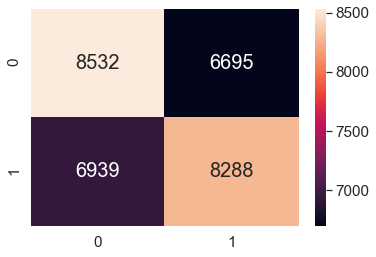

In [76]:
import seaborn as sns
sns.set(font_scale=1.4)#for label size
sns.heatmap(Confusion_metrix_Train_data,annot=True, annot_kws={"size": 20},fmt ="g")

In [78]:
# Applying TF-IDF on Prohect title :


from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer9 = TfidfVectorizer(min_df=10)
vectorizer9.fit(x_train["clean_titles"].values)

x_tain_project_titles_tfidf = vectorizer9.transform(x_train["clean_titles"].values)
X_cv_project_titles_tfidf = vectorizer9.transform(X_cv["clean_titles"].values)
X_test_project_titles_tfidf = vectorizer9.transform(X_test["clean_titles"].values)


print("After TFIDF vectorizations of the clean_titles , shape of the data after standazing")
print(x_tain_project_titles_tfidf.shape, y_train.shape)
print(X_cv_project_titles_tfidf.shape,Y_cv.shape)
print(X_test_project_titles_tfidf.shape, Y_test.shape)
print("*"*100)

After TFIDF vectorizations of the clean_titles , shape of the data after standazing
(30454, 1555) (30454,)
(10490, 1555) (10490,)
(787, 1555) (787,)
****************************************************************************************************


In [83]:
alpha= 10
print("The Error Plot above shows the best Aplha value as :" , alpha )

The Error Plot above shows the best Aplha value as : 10


In [86]:
#Conclusion--------------------------------------



from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Alpha:Hyper Parameter", " Test AUC"]
x.add_row(["BOW", "Multinomial Naive Bayes", 0.01, 0.55])
x.add_row(["TFIDF", "Multinomial Naive Bayes", 0.01, 0.68])
print(x)

+------------+-------------------------+-----------------------+-----------+
| Vectorizer |          Model          | Alpha:Hyper Parameter |  Test AUC |
+------------+-------------------------+-----------------------+-----------+
|    BOW     | Multinomial Naive Bayes |          0.01         |    0.55   |
|   TFIDF    | Multinomial Naive Bayes |          0.01         |    0.68   |
+------------+-------------------------+-----------------------+-----------+
